<a href="https://colab.research.google.com/github/kridtapon/Chande-Momentum-Oscillator-CMO-SuperTrend/blob/main/Chande_Momentum_Oscillator_(CMO)_%2B_SuperTrend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.2 MB/s eta 0:00:00


In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Chande Momentum Oscillator (CMO)
def calculate_cmo(data, period=14):
    """
    Calculate Chande Momentum Oscillator (CMO).
    """
    close_diff = data['Close'].diff()
    gain = close_diff.where(close_diff > 0, 0)
    loss = -close_diff.where(close_diff < 0, 0)
    sum_gain = gain.rolling(window=period).sum()
    sum_loss = loss.rolling(window=period).sum()
    cmo = 100 * (sum_gain - sum_loss) / (sum_gain + sum_loss)
    return cmo

# Function to calculate SuperTrend
def calculate_supertrend(data, atr_period=10, multiplier=3):
    """
    Calculate SuperTrend indicator.
    """
    high = data['High']
    low = data['Low']
    close = data['Close']

    # Calculate ATR
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=atr_period).mean()

    # Calculate SuperTrend
    upper_band = (high + low) / 2 + (multiplier * atr)
    lower_band = (high + low) / 2 - (multiplier * atr)
    supertrend = pd.Series(index=data.index, dtype='float64')

    in_uptrend = True
    for i in range(len(data)):
        if i == 0:
            supertrend[i] = upper_band[i] if in_uptrend else lower_band[i]
            continue

        if close[i] > supertrend[i - 1]:
            in_uptrend = True
        elif close[i] < supertrend[i - 1]:
            in_uptrend = False

        if in_uptrend:
            supertrend[i] = max(lower_band[i], supertrend[i - 1])
        else:
            supertrend[i] = min(upper_band[i], supertrend[i - 1])

    return supertrend

# Define the stock symbol and time period
symbol = 'META'  # Stock symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate CMO and SuperTrend
df['CMO'] = calculate_cmo(df, period=22)
df['SuperTrend'] = calculate_supertrend(df, atr_period=29, multiplier=4)

# Define Entry and Exit signals based on CMO and SuperTrend
df['SuperTrend_Bullish'] = df['Close'] > df['SuperTrend']
df['Entry'] = (df['CMO'] > 0) & df['SuperTrend_Bullish']
df['Exit'] = (df['CMO'] < 0) & ~df['SuperTrend_Bullish']

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
<ipython-input-17-c7fec861b1ad>:43: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-17-c7fec861b1ad>:43: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

<ipython-input-17-c7fec861b1ad>:46: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-17-c7fec861b1ad>:48: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In 

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            522321.58204
Total Return [%]                       422.321582
Benchmark Return [%]                   180.172856
Max Gross Exposure [%]                      100.0
Total Fees Paid                       5183.490648
Max Drawdown [%]                        32.262691
Max Drawdown Duration                       598.0
Total Trades                                   13
Total Closed Trades                            12
Total Open Trades                               1
Open Trade PnL                       62402.865025
Win Rate [%]                            33.333333
Best Trade [%]                         139.499281
Worst Trade [%]                         -7.271811
Avg Winning Trade [%]                   63.445235
Avg Losing Trade [%]                    -3.756769


In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Function to calculate Chande Momentum Oscillator (CMO)
def calculate_cmo(data, period=14):
    close_diff = data['Close'].diff()
    gain = close_diff.where(close_diff > 0, 0)
    loss = -close_diff.where(close_diff < 0, 0)
    sum_gain = gain.rolling(window=period).sum()
    sum_loss = loss.rolling(window=period).sum()
    cmo = 100 * (sum_gain - sum_loss) / (sum_gain + sum_loss)
    return cmo

# Function to calculate SuperTrend
def calculate_supertrend(data, atr_period=10, multiplier=3):
    high = data['High']
    low = data['Low']
    close = data['Close']

    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=atr_period).mean()

    upper_band = (high + low) / 2 + (multiplier * atr)
    lower_band = (high + low) / 2 - (multiplier * atr)
    supertrend = pd.Series(index=data.index, dtype='float64')

    in_uptrend = True
    for i in range(len(data)):
        if i == 0:
            supertrend[i] = upper_band[i] if in_uptrend else lower_band[i]
            continue

        if close[i] > supertrend[i - 1]:
            in_uptrend = True
        elif close[i] < supertrend[i - 1]:
            in_uptrend = False

        if in_uptrend:
            supertrend[i] = max(lower_band[i], supertrend[i - 1])
        else:
            supertrend[i] = min(upper_band[i], supertrend[i - 1])

    return supertrend

# Define the stock symbol and time period
symbol = 'META'  # Stock symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Optimization Parameters
cmo_periods = range(5, 31)
atr_periods = range(5, 31)
multipliers = [2, 3, 4]

# Results storage
results = []

# Grid Search
for cmo_period, atr_period, multiplier in product(cmo_periods, atr_periods, multipliers):
    # Calculate indicators
    df['CMO'] = calculate_cmo(df, period=cmo_period)
    df['SuperTrend'] = calculate_supertrend(df, atr_period=atr_period, multiplier=multiplier)

    # Define Entry and Exit signals
    df['SuperTrend_Bullish'] = df['Close'] > df['SuperTrend']
    df['Entry'] = (df['CMO'] > 0) & df['SuperTrend_Bullish']
    df['Exit'] = (df['CMO'] < 0) & ~df['SuperTrend_Bullish']

    # Filter data for the test period (2020-2025)
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['Entry'],
        exits=df_test['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    metrics = portfolio.stats()
    results.append({
        'cmo_period': cmo_period,
        'atr_period': atr_period,
        'multiplier': multiplier,
        'final_value': metrics['Total Return [%]']
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best parameters
best_params = results_df.loc[results_df['final_value'].idxmax()]
print("Best Parameters:")
print(best_params)

# Plot equity curve of best parameters
df['CMO'] = calculate_cmo(df, period=int(best_params['cmo_period']))
df['SuperTrend'] = calculate_supertrend(df, atr_period=int(best_params['atr_period']), multiplier=int(best_params['multiplier']))
df['SuperTrend_Bullish'] = df['Close'] > df['SuperTrend']
df['Entry'] = (df['CMO'] > 0) & df['SuperTrend_Bullish']
df['Exit'] = (df['CMO'] < 0) & ~df['SuperTrend_Bullish']

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio.plot().show()

# Display performance metrics
print(portfolio.stats())


Streaming output truncated to the last 5000 lines.
<ipython-input-20-8147aed4519d>:47: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-20-8147aed4519d>:47: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' 

Best Parameters:
cmo_period      22.000000
atr_period      29.000000
multiplier       4.000000
final_value    422.321582
Name: 1400, dtype: float64


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            522321.58204
Total Return [%]                       422.321582
Benchmark Return [%]                   180.172856
Max Gross Exposure [%]                      100.0
Total Fees Paid                       5183.490648
Max Drawdown [%]                        32.262691
Max Drawdown Duration                       598.0
Total Trades                                   13
Total Closed Trades                            12
Total Open Trades                               1
Open Trade PnL                       62402.865025
Win Rate [%]                            33.333333
Best Trade [%]                         139.499281
Worst Trade [%]                         -7.271811
Avg Winning Trade [%]                   63.445235
Avg Losing Trade [%]                    -3.756769


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set

<ipython-input-21-96d50c153974>:38: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-21-96d50c153974>:38: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

<ipython-input-21-96d50c153974>:41: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. I

Best Parameters:
cmo_period      22.000000
atr_period      29.000000
multiplier       4.000000
final_value    422.321582
Name: 1400, dtype: float64


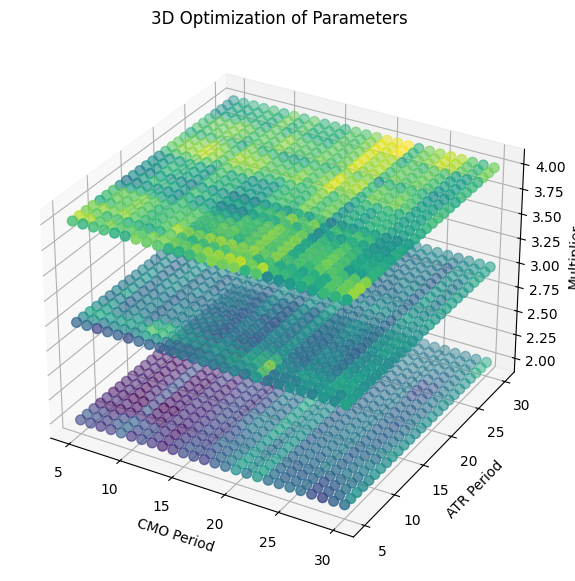

<ipython-input-21-96d50c153974>:38: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-21-96d50c153974>:38: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

<ipython-input-21-96d50c153974>:41: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

<ipython-input-21-96d50c153974>:43: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (cons

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            522321.58204
Total Return [%]                       422.321582
Benchmark Return [%]                   180.172856
Max Gross Exposure [%]                      100.0
Total Fees Paid                       5183.490648
Max Drawdown [%]                        32.262691
Max Drawdown Duration                       598.0
Total Trades                                   13
Total Closed Trades                            12
Total Open Trades                               1
Open Trade PnL                       62402.865025
Win Rate [%]                            33.333333
Best Trade [%]                         139.499281
Worst Trade [%]                         -7.271811
Avg Winning Trade [%]                   63.445235
Avg Losing Trade [%]                    -3.756769


/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



In [21]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to calculate Chande Momentum Oscillator (CMO)
def calculate_cmo(data, period=14):
    close_diff = data['Close'].diff()
    gain = close_diff.where(close_diff > 0, 0)
    loss = -close_diff.where(close_diff < 0, 0)
    sum_gain = gain.rolling(window=period).sum()
    sum_loss = loss.rolling(window=period).sum()
    cmo = 100 * (sum_gain - sum_loss) / (sum_gain + sum_loss)
    return cmo

# Function to calculate SuperTrend
def calculate_supertrend(data, atr_period=10, multiplier=3):
    high = data['High']
    low = data['Low']
    close = data['Close']

    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    atr = tr.rolling(window=atr_period).mean()

    upper_band = (high + low) / 2 + (multiplier * atr)
    lower_band = (high + low) / 2 - (multiplier * atr)
    supertrend = pd.Series(index=data.index, dtype='float64')

    in_uptrend = True
    for i in range(len(data)):
        if i == 0:
            supertrend[i] = upper_band[i] if in_uptrend else lower_band[i]
            continue

        if close[i] > supertrend[i - 1]:
            in_uptrend = True
        elif close[i] < supertrend[i - 1]:
            in_uptrend = False

        if in_uptrend:
            supertrend[i] = max(lower_band[i], supertrend[i - 1])
        else:
            supertrend[i] = min(upper_band[i], supertrend[i - 1])

    return supertrend

# Define the stock symbol and time period
symbol = 'META'  # Stock symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Optimization Parameters
cmo_periods = range(5, 31)
atr_periods = range(5, 31)
multipliers = [2, 3, 4]

# Results storage
results = []

# Grid Search
for cmo_period, atr_period, multiplier in product(cmo_periods, atr_periods, multipliers):
    # Calculate indicators
    df['CMO'] = calculate_cmo(df, period=cmo_period)
    df['SuperTrend'] = calculate_supertrend(df, atr_period=atr_period, multiplier=multiplier)

    # Define Entry and Exit signals
    df['SuperTrend_Bullish'] = df['Close'] > df['SuperTrend']
    df['Entry'] = (df['CMO'] > 0) & df['SuperTrend_Bullish']
    df['Exit'] = (df['CMO'] < 0) & ~df['SuperTrend_Bullish']

    # Filter data for the test period (2020-2025)
    df_test = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df_test['Close'],
        entries=df_test['Entry'],
        exits=df_test['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    # Store performance metrics
    metrics = portfolio.stats()
    results.append({
        'cmo_period': cmo_period,
        'atr_period': atr_period,
        'multiplier': multiplier,
        'final_value': metrics['Total Return [%]']
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Find the best parameters
best_params = results_df.loc[results_df['final_value'].idxmax()]
print("Best Parameters:")
print(best_params)

# Plot 3D optimization results
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the parameters and final_value
ax.scatter(
    results_df['cmo_period'],
    results_df['atr_period'],
    results_df['multiplier'],
    c=results_df['final_value'],
    cmap='viridis',
    s=50
)

# Labels and title
ax.set_xlabel('CMO Period')
ax.set_ylabel('ATR Period')
ax.set_zlabel('Multiplier')
ax.set_title('3D Optimization of Parameters')

# Show the plot
plt.show()

# Plot equity curve of best parameters
df['CMO'] = calculate_cmo(df, period=int(best_params['cmo_period']))
df['SuperTrend'] = calculate_supertrend(df, atr_period=int(best_params['atr_period']), multiplier=int(best_params['multiplier']))
df['SuperTrend_Bullish'] = df['Close'] > df['SuperTrend']
df['Entry'] = (df['CMO'] > 0) & df['SuperTrend_Bullish']
df['Exit'] = (df['CMO'] < 0) & ~df['SuperTrend_Bullish']

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

portfolio.plot().show()

# Display performance metrics
print(portfolio.stats())
